# 德邦期货代码

In [1]:
import pandas as pd
import numpy as np
import warnings
import os
warnings.filterwarnings("ignore")

# 训练集时间（包括首尾）
start_year=2015
end_year=2023

# 测试集时间（包括首尾）
test_start_year = 2024
test_end_year = 2025

base='y2'      # 回测的收益率计算基准 y为当日的收-开, y2为第二天的开-当日开 
contract='T' # 合约代码 暂时只支持 T,TF,  TL因为数据不够全，所以跑步了，从wind直接收取的数据只有从2023-04-21开始的


labels = ['Annualized Return%', 'Sharpe Ratio', 'Max Drawdown%','wining rate%'] # 评价指标
top_n_list = [-1, -1,-1, -1]  # 评价指标对应的前几名 , 最终将会取交集
# 测试了下 5 0 2 5 的 y 效果还不错

连接wind收取相关数据

In [2]:
'''
获取的基本数据， 和宏观经济指标, 在这里已经进行了ffill处理。
'''
import sys
sys.path.append("/Applications/Wind API.app/Contents/python")

from WindPy import *
import pandas as pd
import numpy as np
def fetch_wind_data():
    # 启动WindPy接口
    ret = w.start()
    if not ret.ErrorCode == 0:
        raise Exception("WindPy启动失败")
    
    # 检查是否连接成功
    ret = w.isconnected()
    if not ret:
        raise Exception("WindPy未连接")

    # 提取TF和T的初始行情数据
    TF5 = w.wsd('TF.CFE', ['CLOSE', 'HIGH', 'LOW', 'OPEN', 'volume'], '2014-05-05', usedf=True)
    TF = TF5[1].copy()
    TF10 = w.wsd('T.CFE', ['CLOSE', 'HIGH', 'LOW', 'OPEN', 'volume'], '2015-03-20', usedf=True)
    T = TF10[1].copy()
    TL30 = w.wsd('TL.CFE', ['CLOSE', 'HIGH', 'LOW', 'OPEN', 'volume'], '2015-04-22', usedf=True)
    TL = TL30[1].copy()

    # 宏观数据，开始时间是2014-01-02，初始的缺失值用0填充
    ids = ["S0029657", "S0059749", "S0059744", "S0059747", "M0067855", "G0000886", "G0000889", "G0000891", 
           "G1306752", "G0006352", "G0006353", "M0000612", "M0001227", "M0074417", "M1004524", "M1004520", 
           "M0048486", "M0048488", "M0048490", "M0096868", "M0017142", "M0017141", "M0017145", "M1001854", 
           "S0181383", "S5808575", "S0031525", "M5525763", "M0041653", "M0041652",
           #新加的因子（27个）
          "M1004263","M1004267","M1004271","L4530250","U0737658","O8195887",
            "W6109272","U5267974","Y1667217","W1775339","U9659646","A0239140",
           "F2827408","Z6496161","Y4138099","M0041372","M0041374",
           "M0041378","M0329655","M1004899","M1004900","M1004902",'S0059745',
           'S0059752','M1004264','M1004274','W8696400']
    macro = w.edb(ids, beginTime="2014-01-02", ShowBlank=0, usedf=True)

    #将macro和行情数据拼接在一起
    macro_final = macro[1].copy()

    T= T.reset_index()
    T = T.rename(columns={'index': 'date'})
    TF= TF.reset_index()
    TF= TF.rename(columns={'index': 'date'})
    TL= TL.reset_index()
    TL= TL.rename(columns={'index': 'date'})   
    
    TF.columns = [col.lower() for col in TF.columns]
    T.columns = [col.lower() for col in T.columns]
    TL.columns = [col.lower() for col in TL.columns]


    #向前填充macro_final缺失值
    macro_final.replace(0, np.nan, inplace=True)  # Replace 0 with NA for proper forward fill
    macro_final.fillna(method='ffill', inplace=True)    
    macro_final = macro_final.fillna(macro_final.mean())
    macro_final= macro_final.reset_index()
    macro_final= macro_final.rename(columns={'index': 'date'})

    #分别合并TF,T
    merged_TF = pd.merge(TF, macro_final, on='date', how='left') 
    merged_T = pd.merge(T, macro_final, on='date', how='left')
    merged_TL = pd.merge(TL, macro_final, on='date', how='left')

    w.stop()
    return merged_TF, merged_T, merged_TL


TF, T, TL = fetch_wind_data()
#TF.to_csv("TF.csv",index=False)
T.to_csv("T.csv",index=False)
#TL.to_csv("TL.csv",index=False)
T.tail(10)

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2024 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


,date,close,high,low,open,volume,S0029657,S0059749,S0059744,S0059747,...,M0041378,M0329655,M1004899,M1004900,M1004902,S0059745,S0059752,M1004264,M1004274,W8696400
2576,2025-10-24,108.005,108.065,107.970,108.000,67873.0,-13.9,1.8486,1.4716,1.6174,...,1000.0,200.0,1.5989,1.6442,1.6800,1.4923,2.2126,1.7061,2.3783,1.8450
2577,2025-10-27,108.175,108.180,107.915,107.950,75942.0,-13.9,1.8423,1.4621,1.6054,...,1000.0,200.0,1.6038,1.6463,1.6761,1.4814,2.2031,1.7011,2.3688,1.7950
2578,2025-10-28,108.415,108.455,108.295,108.295,75068.0,-13.9,1.8179,1.4311,1.5724,...,1000.0,200.0,1.5915,1.6338,1.6625,1.4408,2.1700,1.6836,2.3358,1.8130
2579,2025-10-29,108.570,108.640,108.340,108.350,91358.0,-13.9,1.8208,1.3918,1.5783,...,1000.0,200.0,1.5864,1.6245,1.6410,1.4063,2.1770,1.6636,2.3428,1.8130
2580,2025-10-30,108.630,108.680,108.545,108.580,68993.0,-13.9,1.8098,1.3831,1.5609,...,1000.0,200.0,1.5817,1.6113,1.6400,1.4067,2.1625,1.6461,2.3283,1.8025
2581,2025-10-31,108.680,108.725,108.605,108.635,66178.0,-13.9,1.7954,1.3826,1.5662,...,1000.0,200.0,1.5625,1.6010,1.6325,1.4022,2.1431,1.6336,2.3089,1.7925
2582,2025-11-03,108.680,108.710,108.580,108.650,65902.0,-13.9,1.7944,1.3892,1.5768,...,1000.0,200.0,1.5642,1.6053,1.6325,1.4143,2.1376,1.6386,2.3033,1.7900
2583,2025-11-04,108.660,108.680,108.555,108.665,66835.0,-13.9,1.7984,1.3926,1.5795,...,1000.0,200.0,1.5713,1.6152,1.6400,1.4233,2.1421,1.6436,2.3079,1.7900
2584,2025-11-05,108.620,108.750,108.600,108.715,56314.0,-13.9,1.7964,1.4040,1.5794,...,1000.0,200.0,1.5650,1.6100,1.6375,1.4310,2.1391,1.6436,2.3048,1.7925
2585,2025-11-06,108.620,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
data=pd.read_csv(f"{contract}.csv")
os.remove(f"{contract}.csv")

contract=f'{contract}_{base}' # 修正为文件夹名称
output_dir = f"data/{contract}"
if not os.path.exists(output_dir):
    os.makedirs(output_dir, exist_ok=True)

data=data.dropna()
data.head(5)

,date,close,high,low,open,volume,S0029657,S0059749,S0059744,S0059747,...,M0041378,M0329655,M1004899,M1004900,M1004902,S0059745,S0059752,M1004264,M1004274,W8696400
0,2015-03-20,97.09,97.960,96.530,96.900,3332.0,10.4,3.4958,3.1020,3.2943,...,300.0,198.907104,4.775,4.72,4.755,3.1589,4.1059,3.7495,4.6384,3.480
1,2015-03-23,97.02,97.095,96.840,97.095,1386.0,10.4,3.4933,3.1032,3.3029,...,300.0,198.907104,4.790,4.73,4.760,3.1745,4.1034,3.7740,4.6859,3.485
2,2015-03-24,96.92,97.220,96.875,97.135,1380.0,10.4,3.4841,3.1031,3.3086,...,300.0,198.907104,4.810,4.74,4.770,3.1734,4.1140,3.7952,4.7087,3.495
3,2015-03-25,96.85,97.030,96.760,97.020,1234.0,10.4,3.5037,3.1183,3.3254,...,300.0,198.907104,4.825,4.75,4.770,3.1775,4.1336,3.8033,4.7260,3.500
4,2015-03-26,96.37,96.890,96.370,96.835,1073.0,10.4,3.5440,3.1483,3.3799,...,300.0,198.907104,4.845,4.75,4.770,3.1929,4.1739,3.8717,4.8084,3.520


# 构建各个因子

###  第一篇研报因子

In [4]:
def mom(data, period=10): # 返回的即为指标因子值
    return data['close'] - data['close'].shift(period)   


def cmo(data, period=10): # 返回的即为指标因子值
    delta = data['close'].diff()
    up = delta.apply(lambda x: max(x, 0))  # Up_t
    dn = delta.apply(lambda x: min(x, 0))  # Dn_t

    sum_up = up.rolling(window=period, min_periods=1).sum()
    sum_dn = abs(dn.rolling(window=period, min_periods=1).sum())

    cmo_value = 100 * (sum_up - sum_dn) / (sum_up + sum_dn)
    return cmo_value


def apo(data, short_period=10, long_period=20): # 返回的即为指标因子值
    ma_short = data['close'].rolling(window=short_period).mean()
    ma_long = data['close'].rolling(window=long_period).mean()
    return ma_short - ma_long


def macd(data, short_period=10, long_period=20, signal_period=9):  # 只返回了 hist，用来作为因子值，判断过冷过热等
    def ema(data, period):
        ema = [0] * len(data)  # 初始化 EMA 数组
        multiplier = 2 / (period + 1)
        for i in range(len(data)):
            if i == 0:
                ema[i] = data[i]
            else:
                ema[i] = ((data[i] - ema[i - 1]) * multiplier) + ema[i - 1]
        return ema

    ema_short = ema(data['close'].tolist(), short_period)
    ema_long = ema(data['close'].tolist(), long_period)

    dif = [s - l for s, l in zip(ema_short, ema_long)]
    dea = ema(dif, signal_period)
    hist = [2 * (d - e) for d, e in zip(dif, dea)]

    return hist

def dmi(data, period=10):    # 需要修改因子值，从而去适应后面判断市场状态
    high_diff = data['high'].diff()
    low_diff = -data['low'].diff()
    
    # +DM 和 -DM
    plus_dm = high_diff.where((high_diff > 0) & (high_diff > low_diff), 0.0)
    minus_dm = low_diff.where((low_diff > 0) & (low_diff > high_diff), 0.0)
    
    # 真实波幅 TR
    tr1 = data['high'] - data['low']
    tr2 = abs(data['high'] - data['close'].shift(1))
    tr3 = abs(data['low'] - data['close'].shift(1))
    tr = tr1.combine(tr2, max).combine(tr3, max)
    
    # +DI 和 -DI
    tr_sum = tr.rolling(window=period, min_periods=1).sum()
    plus_di = 100 * (plus_dm.rolling(window=period, min_periods=1).sum() / tr_sum)
    minus_di = 100 * (minus_dm.rolling(window=period, min_periods=1).sum() / tr_sum)
    
    # DX
    dx = 100 * abs((plus_di - minus_di) / (plus_di + minus_di))
    
    # ADX
    adx = dx.rolling(window=period, min_periods=1).mean()
    
    return plus_di, minus_di, adx


def cci(data, period=10):
    tp = (data['high'] + data['low'] + data['close']) / 3
    sma_tp = tp.rolling(window=period, min_periods=1).mean()
    mean_deviation = tp.rolling(window=period).apply(lambda x: np.mean(np.abs(x - np.mean(x))), raw=True)
    cci_value = (tp - sma_tp) / (0.015 * mean_deviation)
    return cci_value


def bopa(data, period=20):
    def bop(data):
        return (data['open'] - data['close']) / (data['high'] - data['low'])
    
    bop_values = bop(data)
    return bop_values.rolling(window=period).mean()


def mfi(data, period=10):
    typical_price = (data['high'] + data['low'] + data['close']) / 3
    raw_money_flow = typical_price * data['volume']
    
    positive_flow = []
    negative_flow = []
    
    for i in range(1, len(data)):
        if typical_price[i] > typical_price[i - 1]:
            positive_flow.append(raw_money_flow[i])
            negative_flow.append(0)
        elif typical_price[i] < typical_price[i - 1]:
            positive_flow.append(0)
            negative_flow.append(raw_money_flow[i])
        else:
            positive_flow.append(0)
            negative_flow.append(0)

    positive_flow = pd.Series(positive_flow).rolling(window=period).sum()
    negative_flow = pd.Series(negative_flow).rolling(window=period).sum()

    money_flow_ratio = positive_flow / negative_flow
    mfi_value = 100 - (100 / (1 + money_flow_ratio))
    
    # 为保持与原始数据对齐，向前填充第一个周期的 NaN 值
    mfi_value = pd.Series([None] + mfi_value.tolist())

    return mfi_value

def aroon(data, period=25):
    aroon_up = 100 * ((period - (period - (data['high'].rolling(window=period).apply(lambda x: list(x).index(max(x)), raw=True)))) / period)
    aroon_down = 100 * ((period - (period - (data['low'].rolling(window=period).apply(lambda x: list(x).index(min(x)), raw=True)))) / period)
    return aroon_up-aroon_down


# 第一篇研报的九个指标（十个因子）


# 计算 10 天动量
data['mom'] = mom(data, period=10)    

# 计算 10 天 CMO
data['cmo'] = cmo(data, period=10)

# 计算 MA10 - MA20 的 APO
data['apo'] = apo(data, short_period=10, long_period=20)

#计算 MACD (MA10 - MA20) 并生成 DIF, DEA 和 HIST
data['macd']=macd(data)

# 计算 10天 DMI (其实是两个指标  PDI 和 MDI  ADX和ADXR )
data['pdi'], data['mdi'], data['adx'] = dmi(data, period=10)     
# data['adxr'] = (data['adx'] + data['adx'].shift(9)) / 2   # 补充了一个ADXR

#计算 10 天 CCI
data['cci'] = cci(data, period=10)

# 使用 BOP 的 20 天均值生成 BOPA
data['bopa'] = bopa(data, period=20)

# 计算 10 天 MFI
data['mfi'] = mfi(data, period=10)

# 计算25天的AROON
data['ao'] = aroon(data, period=25)


### 第二篇研报因子

In [5]:
def bbi(data):
    ma3 = data['close'].rolling(window=3).mean()
    ma6 = data['close'].rolling(window=6).mean()
    ma12 = data['close'].rolling(window=12).mean()
    ma24 = data['close'].rolling(window=24).mean()
    bbi_value = (ma3 + ma6 + ma12 + ma24) / 4
    return bbi_value

def bbi_sig(data):
    bbi_val = data['bbi']
    bbi_sig_value = (bbi_val - bbi_val.shift(1)) / bbi_val.shift(1)
    return bbi_sig_value

# 计算 TR, DMZ, 和 DMF
def dmz_dmf(data):
    tr = data['high'] - data['low']
    dmz = tr.where((data['high'] + data['low']) > (data['high'].shift(1) + data['low'].shift(1)), 0)
    dmf = tr.where((data['high'] + data['low']) < (data['high'].shift(1) + data['low'].shift(1)), 0)
    return tr, dmz, dmf

# 计算 DIZ 和 DIF
def diz_dif(data, period=10):
    tr, dmz, dmf = dmz_dmf(data)
    sum_dmz = dmz.rolling(window=period, min_periods=1).sum()
    sum_dmf = dmf.rolling(window=period, min_periods=1).sum()
    sum_tr = sum_dmz + sum_dmf
    diz = sum_dmz / sum_tr
    dif = sum_dmf / sum_tr
    return diz, dif

# 计算 DDI
def ddi(data, period_dif=10, period_diz=10, period_ddi=10):
    diz, dif = diz_dif(data, period_diz)
    ddi_val = diz - dif
    ddi_sma = ddi_val.rolling(window=period_ddi, min_periods=1).mean()
    return ddi_val

# 计算 ADD 指标
def add(data, period_add=10):
    ddi_vals = data['ddi'].tolist()
    add_vals = []
    for t in range(len(ddi_vals)):
        if t < period_add - 1:
            add_vals.append(None)
        else:
            numerator = sum((11 - i) * ddi_vals[t + 1 - i] for i in range(1, 11))
            denominator = sum(range(1, 11))
            add_vals.append(numerator / denominator)
    return pd.Series(add_vals)

# 计算 AD 指标
def ad(data, period_ad=5):
    add_vals = data['add'].rolling(window=period_ad, min_periods=1).sum()
    return add_vals / period_ad

#  计算 DMA
def dma(data, short_period=10, long_period=20, ama_period=10):
    # 计算短期和长期移动平均线
    ma_short = data['close'].rolling(window=short_period).mean()
    ma_long = data['close'].rolling(window=long_period).mean()
    
    # 计算 DIF
    dif = ma_short - ma_long
    
    # 计算 AMA
    ama = dif.rolling(window=ama_period).mean()
    
    return dif,ama

# 计算 SAR
def sar(data, initial_af=0.02, step_af=0.02, max_af=0.2, accel_period=5):
    sar = [0] * len(data)
    af = initial_af
    uptrend = True

    # 初始化 SAR 和 EP
    ep = data['low'][0] if uptrend else data['high'][0]
    sar[0] = data['low'][0] if uptrend else data['high'][0]
    
    for i in range(1, len(data)):
        prev_sar = sar[i - 1]
        prev_ep = ep
        prev_af = af

        # 判断条件
        if i >= 2 * accel_period:
            cond1 = (i >= accel_period and
                 data['close'][i] > max(data['close'][i - accel_period], data['close'][i - 2 * accel_period]) and
                 data['high'][i] > data['high'][i - 1])
            cond2 = (i >= accel_period and
                 data['close'][i] < min(data['close'][i - accel_period], data['close'][i - 2 * accel_period]) and
                 data['low'][i] < data['low'][i - 1])
        else:
            cond1 = cond2 = False

        # 更新加速因子 AF
        if uptrend:
            if cond1:
                af = min(max_af, prev_af + step_af)
            else:
                af = 0.02
        else:
            if cond2:
                af = min(max_af, prev_af + step_af)
            else:
                af = 0.02

        # 更新极值点 EP
        if uptrend:
            ep = max(prev_ep, data['high'][i])
        else:
            ep = min(prev_ep, data['low'][i])

        # 计算当前 SAR
        sar[i] = prev_sar + prev_af * (ep - prev_sar)

        # 判断反转
        if uptrend:
            if data['low'][i] < sar[i]:
                uptrend = False
                sar[i] = prev_ep
                ep = data['low'][i]
                af = initial_af
            else:
                ep = max(ep, data['high'][i])
        else:
            if data['high'][i] > sar[i]:
                uptrend = True
                sar[i] = prev_ep
                ep = data['high'][i]
                af = initial_af
            else:
                ep = min(ep, data['low'][i])

        # 约束 SAR 的最终值
        if i >= accel_period:
            if uptrend:
                sar[i] = min(sar[i], min(data['low'][i - accel_period:i + 1]))
            else:
                sar[i] = max(sar[i], max(data['high'][i - accel_period:i + 1]))

    return pd.Series(sar)


def trix_and_trma(data):
    close_prices = data['close']
    ax_values = np.zeros(len(close_prices))
    bx_values = np.zeros(len(close_prices))
    trix_values = np.zeros(len(close_prices))
    trma_values = np.zeros(len(close_prices))
    
    # Calculate AX_T
    for t in range(len(close_prices)):
        if t == 0:
            ax_values[t] = 0
        elif t == 1:
            ax_values[t] = (9/11) * close_prices[t-1] + (2/11) * close_prices[t]
        else:
            ax_values[t] = (9/11) * ax_values[t-1] + (2/11) * close_prices[t]
    
    # Calculate BX_T
    for t in range(len(close_prices)):
        if t == 0 or t == 1:
            bx_values[t] = 0
        elif t == 2:
            bx_values[t] = (9/11) * ax_values[0] + (2/11) * ax_values[1]
        else:
            bx_values[t] = (9/11) * bx_values[t-1] + (2/11) * ax_values[t]
    
    # Calculate TRIX_T
    for t in range(len(close_prices)):
        if t < 3:
            trix_values[t] = 0
        elif t == 3:
            trix_values[t] = (9/11) * bx_values[0] + (2/11) * bx_values[1]
        else:
            trix_values[t] = (9/11) * trix_values[t-1] + (2/11) * bx_values[t]
    
    # Calculate TRMA_T
    for t in range(len(close_prices)):
        if t < 9:
            trma_values[t] = 0
        else:
            trma_values[t] = close_prices[t] - np.sum(trix_values[t-9:t+1]) / 10
    
    trix_series = pd.Series(trix_values, index=data.index)
    trma_series = pd.Series(trma_values, index=data.index)
    
    return trix_series, trma_series

def kdj(data, period=9):
    # 计算 RSV
    low_min = data['low'].rolling(window=period, min_periods=1).min()
    high_max = data['high'].rolling(window=period, min_periods=1).max()
    rsv = (data['close'] - low_min) / (high_max - low_min) * 100

    # 初始化 %K 和 %D
    k = [50] * len(rsv)
    d = [50] * len(rsv)

    # 计算 %K 和 %D
    for i in range(1, len(rsv)):
        k[i] = (2 / 3) * k[i - 1] + (1 / 3) * rsv[i]
        d[i] = (2 / 3) * d[i - 1] + (1 / 3) * k[i]

    # 计算 %J
    j = [3 * k[i] - 2 * d[i] for i in range(len(k))]

    return  pd.Series(j)

def rsi(data, period=10):
    # 计算每日价格变化
    delta = data['close'].diff()

    # 将涨幅和跌幅分开计算
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    # 计算平均涨幅和平均跌幅
    avg_gain = gain.rolling(window=period, min_periods=1).mean()
    avg_loss = loss.rolling(window=period, min_periods=1).mean()

    # 计算 RS 和 RSI
    rs = avg_gain / avg_loss
    rsi_value = 100 - (100 / (1 + rs))

    return rsi_value

def roc(data, period=5):
    n_period_ago = data['close'].shift(period)
    roc_value = (data['close'] - n_period_ago) / n_period_ago *100
    return roc_value

def maroc(data, roc_values, period=10):
    """计算 MAROC 指标"""
    return roc_values.rolling(window=period, min_periods=1).mean()

def bias(data, period=10):
    """计算 BIAS 指标"""
    moving_average = data['close'].rolling(window=period, min_periods=1).mean()
    bias_value = (data['close'] - moving_average) / moving_average * 100
    return bias_value


def osc(data, period=10):
    moving_average = data['close'].rolling(window=period, min_periods=1).mean()
    osc_value = data['close'] - moving_average
    return osc_value
def oscma1(osc_values, period=10):
    weights = [11 - i for i in range(1, period + 1)]
    weight_sum = sum(range(1, period + 1))
    oscma_values = [0] * len(osc_values)

    for t in range(period - 1, len(osc_values)):
        weighted_sum = sum(weights[i] * osc_values[t + 1 - period + i] for i in range(period))
        oscma_values[t] = 100 * weighted_sum / weight_sum

    return oscma_values

def wr(data, period=9):
    highest_high = data['high'].rolling(window=period, min_periods=1).max()
    lowest_low = data['low'].rolling(window=period, min_periods=1).min()
    wr_value = (highest_high - data['close']) / (highest_high - lowest_low)*100 
    return wr_value


# 第二篇研报的补充的11个因子

# 计算 BBI
data['bbi'] = bbi(data)
data['bbi'] = bbi_sig(data)

# 计算DDI
data['ddi'] = ddi(data, period_dif=10, period_diz=10, period_ddi=10)
data['add'] = add(data, period_add=10)
data['ad'] = ad(data, period_ad=5)

# 计算 DMA
data['dma'], data['ama']= dma(data, short_period=10, long_period=20, ama_period=10)

# 计算 SAR
data['sar'] = sar(data)

# 计算 TRIX 和 TRMA
data['trix'], data['trma']= trix_and_trma(data)

#计算 KDJ
data['kdj'] = kdj(data, period=9)

#计算 RSI
data['rsi'] = rsi(data, period=10)

# 10 天 ROC 和 MAROC
data['roc'] = roc(data, period=10)
# data['maroc'] = maroc(data, data['roc'], period=10)

#计算 10 天 BIAS
data['bias'] = bias(data, period=10)

#计算 10 天 OSC
data['osc']= osc(data, period=10)
# data['oscma']=oscma1(data['osc'],period=10)

# 计算 9天 WR
data['wr'] = wr(data, period=9)

In [6]:
"""
有问题因子：
需要修改为复杂因子
    dmi指标
        需要几个因子值联合判断，而不是单一因子进行判断

    阿隆指标
        需要几个因子值联合判断，而不是单一因子进行判断

    sar
        因子的计算方式有问题
        因子最终的取值范围明显不对
        不过方向是对的"
"""

'\n有问题因子：\n需要修改为复杂因子\n    dmi指标\n        需要几个因子值联合判断，而不是单一因子进行判断\n\n    阿隆指标\n        需要几个因子值联合判断，而不是单一因子进行判断\n\n    sar\n        因子的计算方式有问题\n        因子最终的取值范围明显不对\n        不过方向是对的"\n'

### 研报外，额外补充因子

In [7]:
def ema(data, period):
    return data.ewm(span=period, adjust=False).mean()

def tema(data, period=9):
    ema1 = ema(data['close'], period)
    ema2 = ema(ema1, period)
    ema3 = ema(ema2, period)
    return 3 * ema1 - 3 * ema2 + ema3

def vhf(data, period=28):
    high_max = data['high'].rolling(window=period).max()
    low_min = data['low'].rolling(window=period).min()
    close_diff = abs(data['close'] - data['close'].shift(period))
    close_diff = close_diff.replace(0, 1e-6)     # Avoid division by zero
    return (high_max - low_min) / close_diff

def cmf(data, period=20):
    mfv = ((data['close'] - data['low']) - (data['high'] - data['close'])) / (data['high'] - data['low']) * data['volume']
    return mfv.rolling(window=period).sum() / data['volume'].rolling(window=period).sum()

def vris(data, period=12):
    return (data['volume'] - data['volume'].shift(period)) / data['volume'].shift(period) * 100

def stochastic_k(data, period=14):
    low_min = data['low'].rolling(window=period).min()
    high_max = data['high'].rolling(window=period).max()
    return 100 * (data['close'] - low_min) / (high_max - low_min)

def stochastic_d(data, k_period=14, d_period=3):
    k = stochastic_k(data, k_period)
    return k.rolling(window=d_period).mean()

def relative_index(data, period=14):
    delta = data['close'].diff()
    gain = delta.where(delta > 0, 0.0).rolling(window=period).sum()
    loss = -delta.where(delta < 0, 0.0).rolling(window=period).sum()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def cvi(data, period=20):
    daily_volatility = (data['high'] - data['low']) / data['close']
    return daily_volatility.rolling(window=period).sum()

# 额外补充的因子
data['tema'] = tema(data)
data['vhf'] = vhf(data)
data['cmf'] = cmf(data)
data['vris'] = vris(data)
data['k'] = stochastic_k(data)
data['d'] = stochastic_d(data)
data['ri'] = relative_index(data)
data['cvi'] = cvi(data)

合计共四十个因子

### 计算Y

In [8]:
data['y'] = (data['close']-data['open'])/data['open']*100   # 当日的收-开
data['y2'] = (data['open'].shift(-1)-data['open'])/data['open']*100# 第二天的开-当日开 

# 进行回测

因子挑选

In [9]:
data['date'] = pd.to_datetime(data['date'])
data=data.reset_index(drop=True)

# 删去了 dmi  ，用pdi和mdi替代
# 删去了 mtm ， 用mom替代

# 选择需要的因子
indicators = [
    "macd", "bbi", "ad", "ama", "pdi","mdi", 'mom',"sar",
    "kdj", "rsi", "roc", "bias", "cci", "osc", "cmo", "apo", 'ao',
     "bopa", "mfi", "wr", 'tema', 'vhf', 'cmf', 'vris', 'k', 'd', 'ri', 'cvi']

data.tail(5)

,date,close,high,low,open,volume,S0029657,S0059749,S0059744,S0059747,...,tema,vhf,cmf,vris,k,d,ri,cvi,y,y2
2580,2025-10-30,108.63,108.680,108.545,108.580,68993.0,-13.9,1.8098,1.3831,1.5609,...,108.559668,1.451087,0.211878,-45.161393,93.865031,92.877074,73.550725,0.037564,0.046049,0.050654
2581,2025-10-31,108.68,108.725,108.605,108.635,66178.0,-13.9,1.7954,1.3826,1.5662,...,108.660730,1.577143,0.167371,-25.945571,94.767442,93.200071,72.862454,0.035881,0.041423,0.013808
2582,2025-11-03,108.68,108.710,108.580,108.650,65902.0,-13.9,1.7944,1.3892,1.5768,...,108.716929,2.029412,0.183026,4.687773,94.444444,94.358972,70.564516,0.035963,0.027612,0.013806
2583,2025-11-04,108.66,108.680,108.555,108.665,66835.0,-13.9,1.7984,1.3926,1.5795,...,108.734260,2.732673,0.241432,-11.495577,91.975309,93.729065,71.721311,0.035487,-0.004601,0.046013
2584,2025-11-05,108.62,108.750,108.600,108.715,56314.0,-13.9,1.7964,1.4040,1.5794,...,108.717452,2.601852,0.209253,-26.495503,84.431138,90.283630,68.571429,0.033391,-0.087384,NaN


### 为每个指标构建阈值,并生成各个指标的交易信号

In [10]:
def calculate_initial_thresholds(df, indicator):  # 市场状态判定条件，返回：历史数据 过热、过冷、转暖、转冷的阈值
    quantiles =  df[indicator].quantile([0.3, 0.4, 0.6, 0.7])

    thresholds = {
        'overheat': quantiles[0.7],  # 过热
        'cool': quantiles[0.3],   # 过冷
        'warming_lower': quantiles[0.4], # 转暖 低
        'warming_upper': quantiles[0.6], # 转暖 高
        'cool_lower': quantiles[0.4], # 转冷 低
        'cool_upper': quantiles[0.6]  # 转冷 高
    }
    return thresholds

def optimize_thresholds(df, indicator, thresholds, window=10): # 根据四个条件对四个状态的阈值进行优化
    results = {}
    percentiles = np.arange(0, 101, 1)

    # 限定阈值选取范围
    median = df[indicator].median()
    std = df[indicator].std()
    df = df[(df[indicator] >= median - 3 * std) & (df[indicator] <= median + 3 * std)]


    # Overheat (Sell)  市场过热，考虑做空
    best_threshold = None
    best_metric = np.inf
    best_up_prob=None
    best_ratio=None
    best_occurrence_prob=None

    for p in percentiles: # 百分比遍历调优
        threshold = np.percentile(df[indicator], p)

        # 条件1：分位数区间
        if threshold < thresholds['overheat']: # 如果小于过热阈值，跳过
            continue 

        #  条件2：发生概率
        df['temp_signal'] = 0
        df.loc[(df[indicator] > threshold) & (df[indicator].shift(1) <= threshold), 'temp_signal'] = -1

        subset = df[df['temp_signal'] == -1]
        occurrence_prob = len(subset) / len(df)
        if occurrence_prob <= 0.01:  # 发生概率小于1%，跳过
            continue

        # 条件3：上涨概率
        future_returns = (df['close'].shift(-window) - df['close']) / df['close']
        future_returns = future_returns.loc[subset.index]
        up_prob = (future_returns > 0).sum() / len(future_returns)

        if up_prob > 0.5:  # 上涨概率大于50%，跳过
            continue

        # 条件4：涨跌比
        down_prob=(future_returns < 0).sum() / len(future_returns)

        up_mean = future_returns[future_returns > 0].mean()
        down_mean = future_returns[future_returns < 0].mean()
        ratio=up_prob * up_mean / ((abs(down_mean) if down_mean != 0 else 1)*(abs(down_prob) if down_prob != 0 else 1))
        if ratio>1:   # 涨跌比大于1，跳过
            continue

        # 对阈值进行优化
        metric = ratio*up_prob

        if metric < best_metric: # 过热是做空，取上涨概率和涨跌比之积最小的值作为卖出阈值
            best_metric = metric
            best_up_prob=up_prob
            best_ratio=ratio
            best_threshold = threshold
            best_occurrence_prob=occurrence_prob
        else:
            continue

    results['overheat'] = {
        'threshold': best_threshold,
        'up_prob':best_up_prob,
        'ratio':best_ratio,
        'metric': best_metric,
        'occurrence_prob': best_occurrence_prob
    }


    # cool (Buy) 市场过冷，考虑做多
    best_threshold = None
    best_metric = -np.inf
    best_up_prob=None
    best_ratio=None
    best_occurrence_prob=None

    for p in percentiles:

        threshold = np.percentile(df[indicator], p)
        if threshold > thresholds['cool']:
            continue

        df['temp_signal'] = 0
        df.loc[(df[indicator] < threshold) & (df[indicator].shift(1) >= threshold), 'temp_signal'] = 1
        subset = df[df['temp_signal'] == 1]
        occurrence_prob = len(subset) / len(df)
        if occurrence_prob <= 0.01:
            continue

        # 条件3：上涨概率
        future_returns = (df['close'].shift(-window) - df['close']) / df['close']
        future_returns = future_returns.loc[subset.index]
        up_prob = (future_returns > 0).sum() / len(future_returns)

        if up_prob < 0.5:  # 上涨概率小于50%，跳过
            continue

        # 条件4：涨跌比
        down_prob=(future_returns < 0).sum() / len(future_returns)

        up_mean = future_returns[future_returns > 0].mean()
        down_mean = future_returns[future_returns < 0].mean()
        ratio=up_prob * up_mean / ((abs(down_mean) if down_mean != 0 else 1)*(abs(down_prob) if down_prob != 0 else 1))
        if ratio<1:   # 涨跌比小于1，跳过
            continue

        # 对阈值进行优化
        metric = ratio*up_prob

        if metric > best_metric: # 过冷是做多，取上涨概率和涨跌比之积最大的值作为买入阈值
            best_metric = metric
            best_up_prob=up_prob
            best_ratio=ratio
            best_threshold = threshold
            best_occurrence_prob=occurrence_prob
        else:
            continue

    results['cool'] = {
        'threshold': best_threshold,
        'up_prob':best_up_prob,
        'ratio':best_ratio,
        'metric': best_metric,
        'occurrence_prob': best_occurrence_prob
    }

    # Turn-Warming (Buy) 市场转暖，考虑做多
    best_threshold = None
    best_metric = -np.inf
    best_up_prob=None
    best_ratio=None
    best_occurrence_prob=None
    
    for p in percentiles:
        threshold = np.percentile(df[indicator], p)
        if threshold < thresholds['warming_lower'] or threshold > thresholds['warming_upper']:
            continue

        
        df['temp_signal'] = 0
        df.loc[(df[indicator] <= thresholds['warming_upper'])&(df[indicator] > threshold) & (df[indicator].shift(1) < df[indicator]), 'temp_signal'] = 1

        subset = df[df['temp_signal'] == 1]
        occurrence_prob = len(subset) / len(df)
        if occurrence_prob <= 0.01:
            continue

        # 条件3：上涨概率
        future_returns = (df['close'].shift(-window) - df['close']) / df['close']
        future_returns = future_returns.loc[subset.index]
        up_prob = (future_returns > 0).sum() / len(future_returns)

        if up_prob < 0.5:  # 上涨概率小于50%，跳过
            continue

        # 条件4：涨跌比
        down_prob=(future_returns < 0).sum() / len(future_returns)

        up_mean = future_returns[future_returns > 0].mean()
        down_mean = future_returns[future_returns < 0].mean()
        ratio=up_prob * up_mean / ((abs(down_mean) if down_mean != 0 else 1)*(abs(down_prob) if down_prob != 0 else 1))
        if ratio<1:   # 涨跌比小于1，跳过
            continue

        # 对阈值进行优化
        metric = ratio*up_prob

        if metric > best_metric: # 转暖是做多，取上涨概率和涨跌比之积最大的值作为买入阈值
            best_metric = metric
            best_up_prob=up_prob
            best_ratio=ratio
            best_threshold = threshold
            best_occurrence_prob=occurrence_prob
        else:
            continue

    results['turn_warm'] = {
        'threshold': best_threshold,
        'up_prob':best_up_prob,
        'ratio':best_ratio,
        'metric': best_metric,
        'occurrence_prob': best_occurrence_prob
    }

    # Turning Cool (Sell)
    best_threshold = None
    best_metric = np.inf
    best_up_prob=None
    best_ratio=None
    best_occurrence_prob=None

    
    for p in percentiles:
        threshold = np.percentile(df[indicator], p)
        if threshold < thresholds['cool_lower'] or threshold > thresholds['cool_upper']:
            continue

        df['temp_signal'] = 0
        df.loc[(df[indicator] >= thresholds['cool_lower'])&(df[indicator] < threshold) & (df[indicator].shift(1) > df[indicator]), 'temp_signal'] = -1
        subset = df[df['temp_signal'] == -1]
        occurrence_prob = len(subset) / len(df)
        if occurrence_prob <= 0.01:
            continue

        # 条件3：上涨概率
        future_returns = (df['close'].shift(-window) - df['close']) / df['close']
        future_returns = future_returns.loc[subset.index]
        up_prob = (future_returns > 0).sum() / len(future_returns)

        if up_prob > 0.5:  # 上涨概率大于50%，跳过
            continue

        # 条件4：涨跌比
        down_prob=(future_returns < 0).sum() / len(future_returns)

        up_mean = future_returns[future_returns > 0].mean()
        down_mean = future_returns[future_returns < 0].mean()
        ratio=up_prob * up_mean / ((abs(down_mean) if down_mean != 0 else 1)*(abs(down_prob) if down_prob != 0 else 1))
        if ratio>1:   # 涨跌比大于1，跳过
            continue

        # 对阈值进行优化
        metric = ratio*up_prob

        if metric < best_metric: # 转冷是做空，取上涨概率和涨跌比之积最小的值作为卖出阈值
            best_metric = metric
            best_up_prob=up_prob
            best_ratio=ratio
            best_threshold = threshold
            best_occurrence_prob=occurrence_prob
        else:
            continue

    results['turn_cool'] = {
        'threshold': best_threshold,
        'up_prob':best_up_prob,
        'ratio':best_ratio,
        'metric': best_metric,
        'occurrence_prob': best_occurrence_prob
    }

    return results

def generate_signals(df, indicator, results, thresholds):
    # 初始化信号和条件列
    df['signal'] = 0
    df['condition'] = 'neutral'  # 默认处于中性状态
    
    # 先处理主要状态：过热和过冷
    if results['overheat']['threshold'] is not None:
        threshold = results['overheat']['threshold']
        df.loc[(df[indicator] > threshold), 'signal'] = -1
        df.loc[(df[indicator] > threshold), 'condition'] = 'overheat'
    
    if results['cool']['threshold'] is not None:
        threshold = results['cool']['threshold']
        df.loc[(df[indicator] < threshold), 'signal'] = 1
        df.loc[(df[indicator] < threshold), 'condition'] = 'cool'
    
    if results['turn_warm']['threshold'] is not None and results['overheat']['threshold'] is not None:
        threshold_warm = results['turn_warm']['threshold']
        threshold_overheat = results['overheat']['threshold']
        
        
        df.loc[(df[indicator] < threshold_overheat) & 
               (df[indicator] >= threshold_warm) , 'signal'] = 1
        df.loc[(df[indicator] < threshold_overheat) & 
               (df[indicator] >= threshold_warm) , 'condition'] = 'turn_warm'
        
    if results['turn_cool']['threshold'] is not None and results['cool']['threshold'] is not None:
        threshold_cool = results['cool']['threshold']
        threshold_turn_cool = results['turn_cool']['threshold']
        
        df.loc[(df[indicator] > threshold_cool) & 
               (df[indicator] <= threshold_turn_cool), 'signal'] = - 1
        df.loc[(df[indicator] > threshold_cool) & 
               (df[indicator] <= threshold_turn_cool), 'condition'] = 'turn_cool'
    
    # 生成连续信号
    df['final_signal'] = df['signal'].copy()
    last_signal = 0
    last_condition = None
    started = False

    for i in range(len(df)):
        if df.at[i, 'signal'] != 0:
            last_signal = df.at[i, 'signal']
            last_condition = df.at[i, 'condition']
            started = True
        elif started:
            df.at[i, 'final_signal'] = last_signal
            df.at[i, 'condition'] = last_condition
    
    return df

def bond_futures_strategy(df, indicator):  # 对每个因子生成信号
    thresholds = calculate_initial_thresholds(df, indicator) # 计算市场状态判定条件
    results = optimize_thresholds(df, indicator, thresholds) # 对市场状态的条件，进行阈值优化
    df = generate_signals(df, indicator, results,thresholds) # 根据阈值对信号进行生成
    return df, results


### 生成最终交易信号，利用指标投票得到

In [11]:
def generate_combined_signals(df, indicators):
    combined_df = df[['date','close','open','y','y2']].copy()
    dict_results={}
    
    for indicator in indicators:
        df_with_signals ,results= bond_futures_strategy(df.copy(), indicator)
        combined_df[indicator+'_value']=df_with_signals[indicator]
        combined_df[indicator+'_sign'] = df_with_signals['final_signal']
        combined_df[indicator+'_condition'] = df_with_signals['condition']
        dict_results[indicator]=results
    return combined_df, dict_results

# 选取 2019-2021 年的数据生成各因子的 因子值，交易信号，所处状态
combined_signals_df ,dict_results= generate_combined_signals(data[(data['date'].dt.year >= start_year)&(data['date'].dt.year <= end_year)].reset_index(drop=True),                                                 
                                                indicators)


temp=combined_signals_df.copy()
temp=temp.rename(columns={'y':'close-open','y2':'next_open-open'})
temp.to_csv(f"data/{contract}/train_factors_data.csv",index=False)



#### 不同市场状态下的因子阈值

In [12]:
def generate_dataframes(indicators, results_dict):
    states = ['overheat', 'cool', 'turn_warm', 'turn_cool']
    dfs = {state: pd.DataFrame(columns=[]) for state in states}

    for indicator in indicators:
        results = results_dict[indicator]
        for state, data in results.items():
            row = {
                '指标': indicator.upper(),
                '阈值':round(data['threshold'], 2) if data['threshold'] is not None else '无',
                '上涨概率%': round(data['up_prob'], 2)*100 if data['up_prob'] is not None else '无',
                '涨跌比': round(data['ratio'], 2) if data['ratio'] is not None else '无',
                '发生概率%': round(data['occurrence_prob'], 4)*100 if data['occurrence_prob'] is not None else '无',
                '筛选值': round(data['metric'], 2) if np.isfinite(data['metric']) else '无',
            }
            dfs[state] = pd.concat([dfs[state], pd.DataFrame([row])], ignore_index=True)
    
    df_thresholds = pd.DataFrame()
    for indicator in indicators:
        row = {
            'indicator': indicator.upper(),
            'overheat': round(results_dict[indicator]['overheat']['threshold'], 2) if results_dict[indicator]['overheat']['threshold'] is not None else '无',
            'cool': round(results_dict[indicator]['cool']['threshold'], 2) if results_dict[indicator]['cool']['threshold'] is not None else '无',
            'turn_warm': round(results_dict[indicator]['turn_warm']['threshold'], 2) if results_dict[indicator]['turn_warm']['threshold'] is not None else '无',
            'turn_cool': round(results_dict[indicator]['turn_cool']['threshold'], 2) if results_dict[indicator]['turn_cool']['threshold'] is not None else '无'
        }
        df_thresholds = pd.concat([df_thresholds, pd.DataFrame([row])], ignore_index=True)
    
    return dfs['overheat'], dfs['cool'], dfs['turn_warm'], dfs['turn_cool'],df_thresholds


df_overheat, df_cool, df_turn_warm, df_turn_cool,thresholds=generate_dataframes(indicators, dict_results)
df_overheat.to_csv(f"data/{contract}/train_overheat.csv",index=False)
df_cool.to_csv(f"data/{contract}/train_cool.csv",index=False)
df_turn_warm.to_csv(f"data/{contract}/train_turn_warm.csv",index=False)
df_turn_cool.to_csv(f"data/{contract}/train_turn_cool.csv",index=False)
thresholds.to_csv(f"data/{contract}/train_thresholds.csv",index=False)
thresholds.head(5)

,indicator,overheat,cool,turn_warm,turn_cool
0,MACD,0.13,-0.12,0.03,-0.02
1,BBI,0.0,-0.0,0.0,无
2,AD,无,-0.22,0.01,无
3,AMA,无,-0.17,-0.02,无
4,PDI,44.54,14.01,20.53,20.53


#### 单因子训练集回测结果 （训练集训练其实用到了未来数据）

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def financial_analysis_tech(df, indicators, base, plot=False):
    df_copy = df.copy()
    
    # 转换收益率 y 为 1 或 -1 
    df_copy['y_acc'] = (df_copy[base] > 0).astype(int)
    df_copy['y_acc'] = df_copy['y_acc'].replace(0, -1)

    results = {
        'Indicator': [],
        'Cumulative Returns': [],
        'Real Returns':[],
        'Annualized Return%': [],
        'Sharpe Ratio': [],
        'Max Drawdown%': [],
        'wining rate%':[]
    }
    
    df_backup = df_copy.copy()
    trading_days = 252
    cumulative_returns_df = pd.DataFrame({'date': df_copy['date']})
    
    
    for indicator in indicators:
        if 'Ensemble' not in indicator:
            indicator = indicator + '_sign'
        cumulative_returns_df[indicator+'_position']=df_copy[indicator]
        df_copy = df_backup.copy()
        df_copy[indicator] = df_copy[indicator].shift(1) # 信号延迟一天，从而避免未来数据
        df_copy.dropna(subset=[indicator], inplace=True)
        
        # 计算准确度
        correct = 0
        for pred, true in zip(df_copy[indicator], df_copy['y_acc']):
            # 预测正确，即做多：1，反之，预测错误：-1
            if pred == true:
                correct += 1
            elif pred== 0:
                correct+=1
        accuracy = correct / len(df_copy[base])*100
        
        # 计算收益
        if base=='y':
            df_copy['net_value']=((df_copy['close']-df_copy['open'])*df_copy[indicator])
            df_copy['returns'] = df_copy['y'] / 100 * df_copy[indicator]
        elif base=='y2':
            df_copy['y2'] = df_copy['y2'].fillna(method='ffill')  # 最后一天的y2为空，填充为前一天的
            df_copy['net_value']=((df_copy['open'].shift(-1)-df_copy['open'])*df_copy[indicator])
            df_copy['returns'] = df_copy['y2'] / 100 * df_copy[indicator]


        # 汇总单因子回测结果

        indicator=indicator.split('_')[0]

        # cumulative returns
        df_copy['cumulative_returns'] = (1 + df_copy['returns']).cumprod()
        cumulative_returns_df[indicator] = df_copy['cumulative_returns']


        # annualized return
        annualized_return = df_copy['cumulative_returns'].iloc[-1]**(trading_days / len(df_copy)) - 1
        
        # Sharpe ratio (Assuming risk-free rate = 0 for simplicity)
        sharpe_ratio = df_copy['returns'].mean() / (df_copy['returns'].std()+0.000001) * (trading_days**0.5)
        
        #  maximum drawdown
        rolling_max = df_copy['cumulative_returns'].cummax()
        drawdown = (df_copy['cumulative_returns'] - rolling_max) / rolling_max
        max_drawdown = drawdown.min()
        
       
        results['Indicator'].append(indicator.upper())
        results['Cumulative Returns'].append(df_copy['cumulative_returns'].iloc[-1])
        results['Annualized Return%'].append(annualized_return*100)
        results['Sharpe Ratio'].append(sharpe_ratio)
        results['Max Drawdown%'].append(max_drawdown*100)
        results['Real Returns'].append(df_copy['net_value'].sum())
        results['wining rate%'].append(accuracy)
        
  
    results_df = pd.DataFrame(results)
    cumulative_returns_df['date'] = pd.to_datetime(cumulative_returns_df['date'])
    
    # 绘制所有因子的净值曲线图
    if plot:
        colors = cm.tab20.colors

        plt.figure(figsize=(14, 7))

        # 为每个指标指定不同的颜色
        for idx, indicator in enumerate(indicators):
            plt.plot(cumulative_returns_df['date'], cumulative_returns_df[indicator], 
                    label=indicator.upper(), color=colors[idx % len(colors)])  # 循环颜色

        plt.xlabel('Date')
        plt.ylabel('Cumulative Returns')
        plt.title('Cumulative Returns Over Time')
        plt.legend()
        plt.grid(True)
        plt.show()

    
    return results_df, cumulative_returns_df

results_df ,cumulative_returns_df= financial_analysis_tech(combined_signals_df, indicators,base)
results_df = results_df.sort_values(by='wining rate%',ascending= False).reset_index(drop=True)

results_df.head(10)

,Indicator,Cumulative Returns,Real Returns,Annualized Return%,Sharpe Ratio,Max Drawdown%,wining rate%
0,SAR,1.000000,0.000,0.000000,0.000000,0.000000,100.000000
1,TEMA,1.000000,0.000,0.000000,0.000000,0.000000,100.000000
2,CVI,1.149712,14.730,1.657194,0.465820,-10.313506,57.830762
3,WR,1.038174,3.690,0.442345,0.136488,-10.201678,54.885460
4,AO,1.082159,7.720,0.934566,0.259206,-10.201678,53.295933
5,MFI,1.098915,9.345,1.117439,0.294836,-8.883427,52.267415
6,AMA,1.076163,7.190,0.868514,0.237649,-10.201678,52.033661
7,BIAS,1.209692,18.720,2.268072,0.572697,-9.265397,51.986910
8,KDJ,1.081861,8.205,0.931291,0.250553,-11.334268,51.940159
9,BBI,1.150323,13.890,1.663553,0.432234,-9.790772,51.753156


### 得到所挑选的因子

In [14]:
selected_indicators = set()

for label, top_n in zip(labels, top_n_list):
    if top_n==-1:
        top_n=len(results_df)
        
    sorted_df = results_df.sort_values(by=label, ascending=False)
    top_indicators = sorted_df.head(top_n)['Indicator'].tolist()
    selected_indicators.update(top_indicators)

selected_indicators = list(selected_indicators)
selected_indicators

['KDJ',
 'MFI',
 'RSI',
 'MACD',
 'CVI',
 'CMO',
 'BIAS',
 'VHF',
 'SAR',
 'BOPA',
 'PDI',
 'MOM',
 'CMF',
 'APO',
 'D',
 'K',
 'MDI',
 'CCI',
 'BBI',
 'AD',
 'VRIS',
 'TEMA',
 'OSC',
 'RI',
 'AO',
 'WR',
 'ROC',
 'AMA']

#### 利用投票合成最终的买入卖出信号 进行回测

##### 测试集中单因子的回测结果 （使用训练集得到的阈值数据，而不是重新训练）

In [15]:
def generate_new_signal(combined_signals_df, threshold=0.8):
    combined_signals2=combined_signals_df.copy()

    def calculate_signal(row, threshold):
        value_counts = row.value_counts()
        most_common_value = value_counts.idxmax()
        most_common_count = value_counts.max()
        if most_common_count / len(row) >threshold:
            return most_common_value
        else:
            return 0

    combined_signal = combined_signals_df[indicator_s].apply(calculate_signal, axis=1, threshold=threshold)
    combined_signals2['Ensemble']=combined_signal
    return combined_signals2


def test_generate_signals(df, indicator, results,thresholds): # 根据阈值优化结果，生成信号
    # 初始化信号和条件列
    df['signal'] = 0
    df['condition'] = 'neutral'  # 默认处于中性状态

    idx = results[results['indicator'] == indicator.upper()].index[0]

    # Overheat (Sell) 
    if results.at[idx,'overheat'] != '无':
        threshold = results.at[idx,'overheat']
        df.loc[(df[indicator] > threshold) , 'signal'] = -1 
        df.loc[(df[indicator] > threshold) , 'condition'] = 'overheat'
    
    # cool (Buy) 
    if results.at[idx,'cool'] != '无':
        threshold = results.at[idx,'cool']
        df.loc[(df[indicator] < threshold), 'signal'] = 1
        df.loc[(df[indicator] < threshold), 'condition'] = 'cool'


    # Turning Warm (Buy)
    if results.at[idx,'turn_warm'] != '无':
        threshold = results.at[idx,'turn_warm']
        if results.at[idx,'overheat'] != '无':
            df.loc[(df[indicator] <results.at[idx,'overheat'])&(df[indicator] > threshold), 'signal'] = 1
            df.loc[(df[indicator] <results.at[idx,'overheat'])&(df[indicator] > threshold), 'condition'] = 'turn_warm'

    # Turning Cool (Sell)
    if results.at[idx,'turn_cool'] != '无':
        threshold = results.at[idx,'turn_cool']
        if results.at[idx,'cool'] != '无':
            df.loc[(df[indicator] >results.at[idx,'cool'])&(df[indicator] <= threshold), 'signal'] = -1
            df.loc[(df[indicator] >results.at[idx,'cool'])&(df[indicator] <= threshold), 'condition'] = 'turn_cool'
        


    # final_signal （用信号填充，生成连续的信号）
    df['final_signal'] = df['signal'].copy()
    last_signal = 0
    last_condition = 'neutral'
    started = False

    for i in range(len(df)):
        if df.at[i, 'signal'] != 0:
            last_signal = df.at[i, 'signal']
            last_condition = df.at[i, 'condition']
            started = True
        elif started:
            df.at[i, 'final_signal'] = last_signal
            df.at[i, 'condition'] = last_condition

    return df


def use_thresholds_sign(df, indicators, thresholds): # 利用训练集得到的数据划分状态得到信号
    combined_df = df[['date','close','open','y','y2']].copy()

    for indicator in indicators:
        thresholds_st = calculate_initial_thresholds(df, indicator) # 计算市场状态判定条件
        df_with_signals = test_generate_signals(df.copy(), indicator, thresholds,thresholds_st)
        combined_df[indicator+'_value']=df_with_signals[indicator]
        combined_df[indicator+'_sign'] = df_with_signals['final_signal']
        combined_df[indicator+'_condition'] = df_with_signals['condition']

    return combined_df
    

indicators = [indicator.lower() for indicator in selected_indicators]
combined_signals1 = use_thresholds_sign(data[(data['date'].dt.year >= test_start_year)&(data['date'].dt.year <= test_end_year)].reset_index(drop=True), indicators,thresholds)

indicator_s = [indicator + '_sign' for indicator in indicators]  # 取出每个因子的信号列
new_combined_signal = generate_new_signal(combined_signals1, threshold=0.5)  # 投票阈值设为0.5，即超过一半的因子预测为1，才预测为1

indicator_s.append('Ensemble')
indicator_s= [indicator.split('_')[0] for indicator in indicators] 
r_df ,cumulative_returns_df1= financial_analysis_tech(new_combined_signal, indicator_s,base)
combined_signals1.to_csv(f"data/{contract}/test_factors_data_2.csv",index=False)
cumulative_returns_df1.to_csv(f"data/{contract}/test_factors_signal_2.csv",index=False)

r_df

,Indicator,Cumulative Returns,Real Returns,Annualized Return%,Sharpe Ratio,Max Drawdown%,wining rate%
0,KDJ,1.027085,2.980,1.528365,0.588308,-2.691007,51.126126
1,MFI,1.026604,2.730,1.501352,0.577485,-2.544968,54.279279
2,RSI,1.005013,0.610,0.284212,0.120565,-2.642069,50.675676
3,MACD,0.987231,-1.325,-0.726724,-0.264257,-3.194876,49.549550
4,CVI,1.021017,2.230,1.187518,0.460090,-2.955873,53.378378
5,CMO,1.005013,0.610,0.284212,0.120565,-2.642069,50.675676
6,BIAS,0.985136,-1.580,-0.846348,-0.308909,-2.766453,49.549550
7,VHF,1.046480,5.040,2.612138,0.990890,-1.953871,53.378378
8,SAR,1.000000,0.000,0.000000,0.000000,0.000000,100.000000
9,BOPA,1.016206,1.760,0.916627,0.358535,-2.436707,48.648649


In [16]:
import matplotlib.pyplot as plt
# 取出 _sign 后缀的列
sign_columns = [col for col in new_combined_signal.columns if col.endswith('_sign')]

# 统计每个指标的变动次数
change_counts = {}
for col in sign_columns:
    change_counts[col] = new_combined_signal[col].diff().abs().sum()

print("各信号变动次数：")
for col, count in change_counts.items():
    print(f"{col}: {count}")

signal=new_combined_signal[['date','close','open','y','y2','Ensemble']].copy()
signal[['date','Ensemble']].to_csv(f"data/{contract}/test_strategy_signal.csv",index=False)
signal

各信号变动次数：
kdj_sign: 149.0
mfi_sign: 64.0
rsi_sign: 246.0
macd_sign: 115.0
cvi_sign: 20.0
cmo_sign: 246.0
bias_sign: 153.0
vhf_sign: 140.0
sar_sign: 0.0
bopa_sign: 144.0
pdi_sign: 196.0
mom_sign: 200.0
cmf_sign: 107.0
apo_sign: 82.0
d_sign: 186.0
k_sign: 57.0
mdi_sign: 142.0
cci_sign: 115.0
bbi_sign: 152.0
ad_sign: 1.0
vris_sign: 60.0
tema_sign: 0.0
osc_sign: 149.0
ri_sign: 7.0
ao_sign: 1.0
wr_sign: 1.0
roc_sign: 188.0
ama_sign: 1.0


,date,close,open,y,y2,Ensemble
0,2024-01-02,102.725,102.935,-0.204012,-0.233157,0
1,2024-01-03,102.815,102.695,0.116851,0.146064,0
2,2024-01-04,102.815,102.845,-0.029170,0.053479,0
3,2024-01-05,102.950,102.900,0.048591,0.063168,0
4,2024-01-08,102.925,102.965,-0.038848,0.038848,1
...,...,...,...,...,...,...
440,2025-10-30,108.630,108.580,0.046049,0.050654,1
441,2025-10-31,108.680,108.635,0.041423,0.013808,1
442,2025-11-03,108.680,108.650,0.027612,0.013806,1
443,2025-11-04,108.660,108.665,-0.004601,0.046013,1


In [17]:
top10 = r_df.nlargest(10, 'Sharpe Ratio')
new_indicator = top10['Indicator']
new_indicator

11    MOM
13    APO
12    CMF
26    ROC
17    CCI
15      K
16    MDI
7     VHF
25     WR
27    AMA
Name: Indicator, dtype: object

In [18]:
def generate_new_signal(combined_signals_df, threshold=0.8):
    combined_signals2=combined_signals_df.copy()

    def calculate_signal(row, threshold):
        value_counts = row.value_counts()
        most_common_value = value_counts.idxmax()
        most_common_count = value_counts.max()
        if most_common_count / len(row) >threshold:
            return most_common_value
        else:
            return 0

    combined_signal = combined_signals_df[indicator_s].apply(calculate_signal, axis=1, threshold=threshold)
    combined_signals2['Ensemble']=combined_signal
    return combined_signals2


def test_generate_signals(df, indicator, results,thresholds): # 根据阈值优化结果，生成信号
    # 初始化信号和条件列
    df['signal'] = 0
    df['condition'] = 'neutral'  # 默认处于中性状态

    idx = results[results['indicator'] == indicator.upper()].index[0]

    # Overheat (Sell) 
    if results.at[idx,'overheat'] != '无':
        threshold = results.at[idx,'overheat']
        df.loc[(df[indicator] > threshold) , 'signal'] = -1 
        df.loc[(df[indicator] > threshold) , 'condition'] = 'overheat'
    
    # cool (Buy) 
    if results.at[idx,'cool'] != '无':
        threshold = results.at[idx,'cool']
        df.loc[(df[indicator] < threshold), 'signal'] = 1
        df.loc[(df[indicator] < threshold), 'condition'] = 'cool'


    # Turning Warm (Buy)
    if results.at[idx,'turn_warm'] != '无':
        threshold = results.at[idx,'turn_warm']
        if results.at[idx,'overheat'] != '无':
            df.loc[(df[indicator] <results.at[idx,'overheat'])&(df[indicator] > threshold), 'signal'] = 1
            df.loc[(df[indicator] <results.at[idx,'overheat'])&(df[indicator] > threshold), 'condition'] = 'turn_warm'

    # Turning Cool (Sell)
    if results.at[idx,'turn_cool'] != '无':
        threshold = results.at[idx,'turn_cool']
        if results.at[idx,'cool'] != '无':
            df.loc[(df[indicator] >results.at[idx,'cool'])&(df[indicator] <= threshold), 'signal'] = -1
            df.loc[(df[indicator] >results.at[idx,'cool'])&(df[indicator] <= threshold), 'condition'] = 'turn_cool'
        


    # final_signal （用信号填充，生成连续的信号）
    df['final_signal'] = df['signal'].copy()
    last_signal = 0
    last_condition = 'neutral'
    started = False

    for i in range(len(df)):
        if df.at[i, 'signal'] != 0:
            last_signal = df.at[i, 'signal']
            last_condition = df.at[i, 'condition']
            started = True
        elif started:
            df.at[i, 'final_signal'] = last_signal
            df.at[i, 'condition'] = last_condition

    return df


def use_thresholds_sign(df, indicators, thresholds): # 利用训练集得到的数据划分状态得到信号
    combined_df = df[['date','close','open','y','y2']].copy()

    for indicator in indicators:
        thresholds_st = calculate_initial_thresholds(df, indicator) # 计算市场状态判定条件
        df_with_signals = test_generate_signals(df.copy(), indicator, thresholds,thresholds_st)
        combined_df[indicator+'_value']=df_with_signals[indicator]
        combined_df[indicator+'_sign'] = df_with_signals['final_signal']
        combined_df[indicator+'_condition'] = df_with_signals['condition']

    return combined_df
    

indicators = [indicator.lower() for indicator in new_indicator]
combined_signals1 = use_thresholds_sign(data[(data['date'].dt.year >= test_start_year)&(data['date'].dt.year <= test_end_year)].reset_index(drop=True), indicators,thresholds)

indicator_s = [indicator + '_sign' for indicator in indicators]  # 取出每个因子的信号列
new_combined_signal = generate_new_signal(combined_signals1, threshold=0.5)  # 投票阈值设为0.5，即超过一半的因子预测为1，才预测为1

indicator_s.append('Ensemble')
indicator_s= [indicator.split('_')[0] for indicator in indicators] 
r_df ,cumulative_returns_df1= financial_analysis_tech(new_combined_signal, indicator_s,base)
combined_signals1.to_csv(f"data/{contract}/test_factors_data.csv",index=False)
cumulative_returns_df1.to_csv(f"data/{contract}/test_factors_signal.csv",index=False)

r_df

,Indicator,Cumulative Returns,Real Returns,Annualized Return%,Sharpe Ratio,Max Drawdown%,wining rate%
0,MOM,1.094761,9.700,5.272829,1.972792,-1.058548,55.405405
1,APO,1.087988,8.970,4.902703,1.836607,-1.922021,54.504505
2,CMF,1.082909,8.575,4.624462,1.746818,-2.000285,54.954955
3,ROC,1.080867,8.340,4.512432,1.692931,-1.488899,53.153153
4,CCI,1.064046,6.490,3.586186,1.352924,-2.012625,56.081081
5,K,1.058290,5.940,3.267787,1.234786,-2.220901,55.630631
6,MDI,1.047547,4.980,2.671474,1.012898,-3.728402,54.954955
7,VHF,1.046480,5.040,2.612138,0.990890,-1.953871,53.378378
8,WR,1.035611,3.690,2.005850,0.837211,-2.209440,65.315315
9,AMA,1.027151,2.825,1.532074,0.684729,-2.209440,69.594595


##### 结果

In [19]:
import matplotlib.pyplot as plt
# 取出 _sign 后缀的列
sign_columns = [col for col in new_combined_signal.columns if col.endswith('_sign')]

# 统计每个指标的变动次数
change_counts = {}
for col in sign_columns:
    change_counts[col] = new_combined_signal[col].diff().abs().sum()

print("各信号变动次数：")
for col, count in change_counts.items():
    print(f"{col}: {count}")

signal=new_combined_signal[['date','close','open','y','y2','Ensemble']].copy()
signal[['date','Ensemble']].to_csv(f"data/{contract}/test_strategy_signal.csv",index=False)


各信号变动次数：
mom_sign: 200.0
apo_sign: 82.0
cmf_sign: 107.0
roc_sign: 188.0
cci_sign: 115.0
k_sign: 57.0
mdi_sign: 142.0
vhf_sign: 140.0
wr_sign: 1.0
ama_sign: 1.0


In [20]:
signal

,date,close,open,y,y2,Ensemble
0,2024-01-02,102.725,102.935,-0.204012,-0.233157,0
1,2024-01-03,102.815,102.695,0.116851,0.146064,1
2,2024-01-04,102.815,102.845,-0.029170,0.053479,1
3,2024-01-05,102.950,102.900,0.048591,0.063168,1
4,2024-01-08,102.925,102.965,-0.038848,0.038848,1
...,...,...,...,...,...,...
440,2025-10-30,108.630,108.580,0.046049,0.050654,1
441,2025-10-31,108.680,108.635,0.041423,0.013808,1
442,2025-11-03,108.680,108.650,0.027612,0.013806,1
443,2025-11-04,108.660,108.665,-0.004601,0.046013,1


# 新十个

In [21]:
from collections import Counter
from datetime import datetime
import pandas as pd
indicators = [
    "macd", "bbi", "ad", "ama", "pdi","mdi", 'mom',"sar",
    "kdj", "rsi", "roc", "bias", "cci", "osc", "cmo", "apo", 'ao',
     "bopa", "mfi", "wr", 'tema', 'vhf', 'cmf', 'vris', 'k', 'd', 'ri', 'cvi']
indicator_month = []
# 获取当前日期
current_date = datetime.now()
# current_date = specified_date
# 初始化一个空列表，用来存储每月末日期
last_days_of_month = []

# 迭代从去年到现在的每个月
for month_offset in range(1,14):  # 12个月
    # 获取当前月份对应的年份
    year = current_date.year - (month_offset // 12)
    month = current_date.month - month_offset % 12
    
    if month <= 0:
        # 如果月份小于1，调整年份，并设置为12月
        year -= 1
        month += 12
    
    # 获取该月的最后一天
    first_day_of_month = datetime(year, month, 1)
    last_day_of_month = first_day_of_month - pd.Timedelta(days=1)
    
    last_days_of_month.append(last_day_of_month)

for last_day_of_previous_month in last_days_of_month:

    # 获取前一个月的最后一天
    # 通过替换日期为当月的第一天，然后减去一天
    # 筛选数据：日期小于等于前一个月的最后一天
   
    train_data = data[data['date'] <= last_day_of_previous_month]
    test_data = data[data['date'] > last_day_of_previous_month]

    # 选取 2019-2021 年的数据生成各因子的 因子值，交易信号，所处状态
    combined_signals_df ,dict_results= generate_combined_signals(train_data.reset_index(drop=True),                                                 
                                                    indicators)
    df_overheat, df_cool, df_turn_warm, df_turn_cool,thresholds=generate_dataframes(indicators, dict_results)
    results_df ,cumulative_returns_df= financial_analysis_tech(combined_signals_df, indicators,base)
    results_df = results_df.sort_values(by='wining rate%',ascending= False).reset_index(drop=True)

    selected_indicators = set()

    for label, top_n in zip(labels, top_n_list):
        if top_n==-1:
            top_n=len(results_df)
            
        sorted_df = results_df.sort_values(by=label, ascending=False)
        top_indicators = sorted_df.head(top_n)['Indicator'].tolist()
        selected_indicators.update(top_indicators)
    selected_indicators = list(selected_indicators)
    indicators = [indicator.lower() for indicator in selected_indicators]
    combined_signals1 = use_thresholds_sign(test_data.reset_index(drop=True), indicators,thresholds)

    indicator_s = [indicator + '_sign' for indicator in indicators]  # 取出每个因子的信号列
    new_combined_signal = generate_new_signal(combined_signals1, threshold=0.5)  # 投票阈值设为0.5，即超过一半的因子预测为1，才预测为1

    indicator_s.append('Ensemble')
    indicator_s= [indicator.split('_')[0] for indicator in indicators] 
    r_df ,cumulative_returns_df1= financial_analysis_tech(new_combined_signal, indicator_s,base)
    top10 = r_df.nlargest(10, 'Sharpe Ratio')
    new_indicator = top10['Indicator']
    new_indicator = new_indicator.tolist()
    for ni in new_indicator:
        indicator_month.append(ni)
# indicator_month = indicator_month.tolist()
counter = Counter(indicator_month)
# 获取出现次数最多的前十个元素
top_10_year = [indicator for indicator, count in counter.most_common(10)]

In [22]:
top_10_year

['CMF', 'MFI', 'VHF', 'APO', 'K', 'RI', 'WR', 'AO', 'PDI', 'D']

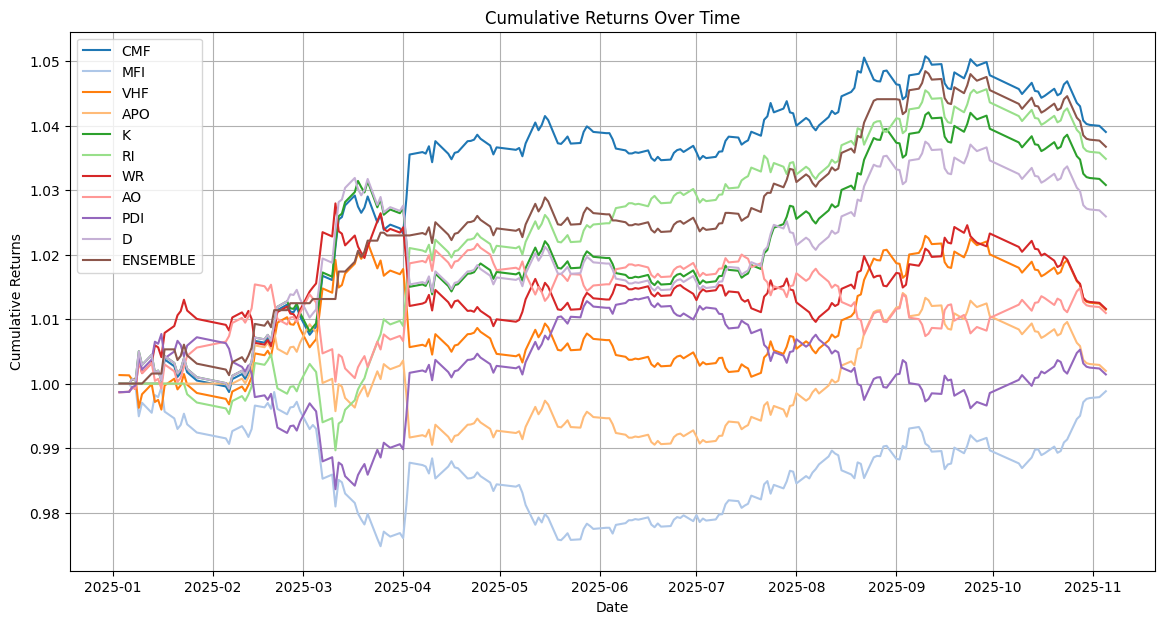

In [23]:
test_start_year = 2025
combined_signals_df ,dict_results= generate_combined_signals(data[(data['date'].dt.year >= test_start_year)&(data['date'].dt.year <= test_end_year)].reset_index(drop=True),                                                 
                                                    indicators)
df_overheat, df_cool, df_turn_warm, df_turn_cool,thresholds=generate_dataframes(indicators, dict_results)
results_df ,cumulative_returns_df= financial_analysis_tech(combined_signals_df, indicators,base)
results_df = results_df.sort_values(by='wining rate%',ascending= False).reset_index(drop=True)
indicators = [indicator.lower() for indicator in top_10_year]
combined_signals1 = use_thresholds_sign(data[(data['date'].dt.year >= test_start_year)&(data['date'].dt.year <= test_end_year)].reset_index(drop=True), indicators,thresholds)

indicator_s = [indicator + '_sign' for indicator in indicators]  # 取出每个因子的信号列
new_combined_signal = generate_new_signal(combined_signals1, threshold=0.5)  # 投票阈值设为0.5，即超过一半的因子预测为1，才预测为1

indicator_s.append('Ensemble')
indicator_s= [indicator.split('_')[0] for indicator in indicator_s]
r_df ,cumulative_returns_df1= financial_analysis_tech(new_combined_signal, indicator_s,base, plot=True)

In [24]:
import matplotlib.pyplot as plt
# 取出 _sign 后缀的列
sign_columns = [col for col in new_combined_signal.columns if col.endswith('_sign')]

# 统计每个指标的变动次数
change_counts = {}
for col in sign_columns:
    change_counts[col] = new_combined_signal[col].diff().abs().sum()

print("各信号变动次数：")
for col, count in change_counts.items():
    print(f"{col}: {count}")

signal=new_combined_signal[['date','close','open','y','y2','Ensemble']].copy()
signal[['date','Ensemble']].to_csv(f"data/{contract}/test_strategy_signal.csv",index=False)


各信号变动次数：
cmf_sign: 21.0
mfi_sign: 77.0
vhf_sign: 38.0
apo_sign: 17.0
k_sign: 37.0
ri_sign: 37.0
wr_sign: 104.0
ao_sign: 16.0
pdi_sign: 36.0
d_sign: 25.0


In [25]:
signal

,date,close,open,y,y2,Ensemble
0,2025-01-02,109.180,109.020,0.146762,0.266006,0
1,2025-01-03,109.440,109.310,0.118928,0.132650,0
2,2025-01-06,109.470,109.455,0.013704,-0.004568,0
3,2025-01-07,109.380,109.450,-0.063956,-0.073093,0
4,2025-01-08,109.425,109.370,0.050288,0.027430,0
...,...,...,...,...,...,...
198,2025-10-30,108.630,108.580,0.046049,0.050654,-1
199,2025-10-31,108.680,108.635,0.041423,0.013808,-1
200,2025-11-03,108.680,108.650,0.027612,0.013806,-1
201,2025-11-04,108.660,108.665,-0.004601,0.046013,-1
